In [18]:
import requests
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
url = "https://www.cupoy.com/newsfeed/topstory"
browser = webdriver.Chrome()
SCROLL_PAUSE_TIME = 1
news_dict = {}

In [19]:
def get_title():
    global news_dict
    html = browser.page_source
    soup = BeautifulSoup(html, "lxml")
    all_news = soup.find_all("div", attrs={'class':'sc-eEieub sc-iuDHTM ibJqYc'})
    for news in all_news:
        title = news.a["title"]
        news_url = news.a["href"]
        news_dict[str(title)]= str(news_url)

In [20]:
browser.get(url) 
time.sleep(3)
last_height = browser.execute_script("return document.body.scrollHeight")
while True:
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    new_height = browser.execute_script("return document.body.scrollHeight")
    last_height = new_height
    get_title()
    l = len(news_dict)
    print("news_length:",l)
    if l >= 700:
        break

news_length: 0
news_length: 0
news_length: 14
news_length: 27
news_length: 30
news_length: 30
news_length: 41
news_length: 54
news_length: 60
news_length: 60
news_length: 60
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 76
news_length: 81
news_length: 81
news_length: 81
news_length: 92
news_length: 105
news_length: 111
news_length: 111
news_length: 122
news_length: 135
news_length: 141
news_length: 141
news_length: 141
news_length: 151
n

In [21]:
import pandas as pd
pd.DataFrame(list(news_dict))

,0
0,2019 新冠肺炎疫情如何影響全球高科技產業 | TechNews 科技新報
1,預期大幅落空，郭明錤稱穩懋 iPhone 訂單將受挫 | TechNews 科技新報
2,武漢肺炎新增有效療法：輸入康復者血漿 | TechNews 科技新報
3,日經：鴻海產能需 1~2 個月才恢復，臺廠遭中國以放大鏡檢視 | TechNews 科技新報
4,美國防部一改反對立場，同意擴大封殺華為 | TechNews 科技新報
...,...
701,《美股》陸確診數暴增、北京拒受美方協助 道瓊臉綠 | MoneyDJ新聞摘錄
702,疫情紓困不分中央地方 韓國瑜直奔政院為自己消毒 | 信傳媒
703,《新冠疫情》：美高梅撤財測，醫護穿紙尿褲進病房 | MoneyDJ新聞摘錄
704,〈美股盤後〉Fed限縮Repo操作 美控華為盜竊商密 道瓊跌逾100點 - Yahoo奇摩理財


In [22]:
def getContent(link_url):
    article = ""
    resp = requests.get(link_url)
    resp.encoding = 'utf-8'
    soup = BeautifulSoup(resp.text, 'lxml')
    news_content = soup.find_all("p")
    for p in news_content:
        if ((p.string) is not None):
            article += p.string
    print(article)
    return article

In [32]:
news_content = {}
for title, news_url in news_dict.items():
    try:
        content = getContent(news_url)
        if len(content) < 200:
            continue
        news_content[title] = content
    except:
        pass

就能夠安心追隨。無論遭遇任何狀況，領導者要和部屬一起克服困難時，始終保持樂觀開朗是重要關鍵。適合當領導者的性格是什麼？人類的性格，有些外向，有些內向。樂觀開朗、喜愛社交的人是外向性格，拘謹靦腆的人是內向性格。外向性格和內向性格的人，各有優缺點，並非外向性格的人就能夠諸事順遂，然而，僅以領導者的觀點而言，外向性格的人容易獲得部屬的愛戴。根據心理學的研究，外向性格的領導者，皆會受到內向性格或是外向性格的人的歡迎，所以容易成為眾人支持的「領導者人選」。談話時，語調低沉緩慢聲音尖銳容易被認為「情緒化的人」對部屬說話時候的聲調，會產生不同的印象。根據大衛．艾丁頓（David W. Addington）的研究，平板聲音的印象是「男性的」、「慵懶的」、「冷淡的」、「消極的」，帶有鼻音的聲音印象是「不符合社會期待」、「令人厭惡的」。另一方面，低沉的聲音，如果是男性，印象則是「現實的」、「圓滑成熟」、「洗鍊」、「適應力強」；如果是女性，印象則是「懶惰的」、「庸俗的」、「死腦筋的」。若是明亮的聲音的話，男性是「洗鍊」、「自尊高」、「藝術人」；女性則是「活潑的」、「社交的」。這種聲音印象或許存在文化差異，不過日本人大致吻合這項研究結果。尤其是許多領導者的聲音特徵，無論男性女性，都是較為低沉、聲量大且清楚。會議討論時，說話聲音如果尖銳，容易造成「情緒化的人」、「缺乏自信的人」等印象。因此在討論時，以低沉穩重的聲音發言，能夠賦予擁有自信、冷靜的印象。人類在緊張的時候，聲調會隨之提高。尖銳的聲音表示緊張，所以首先緩和緊張，就試著以沉穩的聲調發言吧！隨著部屬的理解程度，調整說話的速度除了聲調之外，說話速度也很重要。通常，說話快的人，給予人頭腦靈活的印象。無論對方的發言為何，都能夠像江河流洩般滔滔不絕地反辯的人，常在議論的場合，立於優勢地位。可是，領導者和部屬的討論，目的不在於輸贏。討論的目的是為了指導部屬，如果部屬無法理解談話的內容，則毫無意義。最好是以易於聆聽的聲音，配合部屬理解的程度，放慢速度說話。領導者要成為優秀的人生導師（mentor）只是指導部屬，稱不上是導師導師（mentor）一詞，源自於荷馬《奧德賽》中登場的人物曼托爾（Mentor）。《奧德賽》主角奧德修斯國王出征時，將兒子的教養託付給曼托爾，曼托爾盡心教育王子，以便將來得以勝任一國之君的重責。曼托爾所肩負的教導重任，後來演變引申

In [33]:
import json
with open('news.json', 'w', encoding="utf-8") as json_file:
        json.dump(news_content, json_file, indent=4, ensure_ascii=False)

In [52]:
import jieba
import jieba.analyse
jieba.set_dictionary('./dict.txt.big')
dic = {}
content = ""

with open('news.json', 'r') as json_file:
    dic = json.load(json_file)

for title, article in dic.items():
    content += title + article

with open('content.txt', 'w') as f:
    f.write(content)

jieba.analyse.set_stop_words("stop_words.txt")
tags = jieba.analyse.extract_tags(content, 30)
print(" ".join(tags))

Building prefix dict from /Users/oliver/Desktop/Github/1st-PyCrawlerMarathon/CUPOY/dict.txt.big ...
Loading model from cache /var/folders/wp/hqrj4fw972s76k6mt5blv4yh0000gn/T/jieba.u3e02e943719603cd9f9548568d8d74ac.cache
Loading model cost 1.646 seconds.
Prefix dict has been built successfully.
武漢 中國 媽媽 台灣 肺炎 疫情 口罩 美國 情人節 設計 市場 防疫 確診 服務 團隊 電影 病毒 分享 技術 環境 特別 咖啡 國家 醫院 系統 機會 發現 比賽 產品 報導


In [88]:
table = []
dic = {}
for tag in tags:
    dic[tag]=content.count(tag)
    table.append({"Word":tag, "Count":content.count(tag)})
table.sort(key=lambda x:x["Count"], reverse = True)

In [77]:
import pandas as pd
pd.DataFrame(table)
# table = pd.Series(table)
# table.to_frame()


,Word,Count
0,中國,678
1,武漢,601
2,肺炎,579
3,媽媽,543
4,台灣,507
5,疫情,483
6,病毒,438
7,口罩,413
8,咖啡,373
9,美國,361


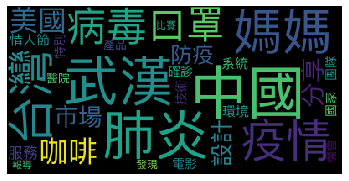

In [92]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
font = "PingFang.ttc"
wc = WordCloud(background_color='black',font_path=font)
wc.generate_from_frequencies(dic)
import matplotlib.pyplot as plt
plt.imshow(wc)
plt.axis("off")
plt.show()